# Introduction

In [1]:
# install River, a Python library for online machine learning.
# !pip install river

import river
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

np.random.seed(42)

More streams are available on river's [API reference](https://riverml.xyz/latest/api/overview/).

In [2]:
# load the Electricity prices in New South Wales data stream from river

dataset = river.datasets.Elec2()

print(dataset)

Electricity prices in New South Wales.

This is a binary classification task, where the goal is to predict if the price of electricity
will go up or down.

This data was collected from the Australian New South Wales Electricity Market. In this market,
prices are not fixed and are affected by demand and supply of the market. They are set every
five minutes. Electricity transfers to/from the neighboring state of Victoria were done to
alleviate fluctuations.

      Name  Elec2                                                      
      Task  Binary classification                                      
   Samples  45,312                                                     
  Features  8                                                          
    Sparse  False                                                      
      Path  /Users/paulmvula/river_data/Elec2/electricity.csv          
       URL  https://maxhalford.github.io/files/datasets/electricity.zip
      Size  2.95 MB                

In [3]:
# print two sample from the data stream 

for x, y in dataset.take(2):

    pprint(x)
    print(y)
    #break

{'date': 0.0,
 'day': 2,
 'nswdemand': 0.439155,
 'nswprice': 0.056443,
 'period': 0.0,
 'transfer': 0.414912,
 'vicdemand': 0.422915,
 'vicprice': 0.003467}
True
{'date': 0.0,
 'day': 2,
 'nswdemand': 0.415055,
 'nswprice': 0.051699,
 'period': 0.021277,
 'transfer': 0.414912,
 'vicdemand': 0.422915,
 'vicprice': 0.003467}
True


In [4]:
# build a a pipeline with a StandardScaler and LogisticRegression

model = river.compose.Pipeline(river.preprocessing.StandardScaler(),
                         river.linear_model.LogisticRegression(river.optim.SGD(lr=0.05)))

# performance metric
metric = river.metrics.Accuracy()

for x, y in dataset:

    y_pred = model.predict_one(x)      # make a prediction
    metric = metric.update(y, y_pred)  # update the metric
    model = model.learn_one(x, y)      # make the model learn

print(metric)

Accuracy: 87.68%


# Concept drift and Drift detection

We will use numpy to generate a stream with **four drifts**

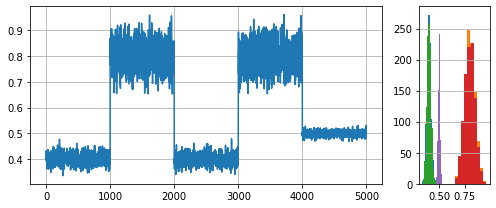

In [5]:
# Generate data for 5 distributions
random_state = np.random.RandomState(seed=42)
dist_a = random_state.normal(0.4, 0.02, 1000)
dist_b = random_state.normal(0.8, 0.05, 1000)
dist_c = random_state.normal(0.4, 0.02, 1000)
dist_d = random_state.normal(0.8, 0.05, 1000)
dist_e = random_state.normal(0.5, 0.01, 1000)

# Concatenate data to simulate a data stream with 4 drifts
stream = np.concatenate((dist_a, dist_b, dist_c, dist_d, dist_e))

# Auxiliary function to plot the data
def plot_data(dist_a, dist_b, dist_c, dist_d, dist_e, drifts=None):
    fig = plt.figure(figsize=(7,3), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[5, 1])
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])
    ax1.grid()
    ax1.plot(stream, label='Stream')
    ax2.grid(axis='y')
    ax2.hist(dist_a, label=r'$dist_a$')
    ax2.hist(dist_b, label=r'$dist_b$')
    ax2.hist(dist_c, label=r'$dist_c$')
    ax2.hist(dist_d, label=r'$dist_d$')
    ax2.hist(dist_e, label=r'$dist_e$')
    if drifts is not None:
        for drift_detected in drifts:
            ax1.axvline(drift_detected, color='red')
    plt.show()

plot_data(dist_a, dist_b, dist_c, dist_d, dist_e)

## Variable window

[ADWIN](https://riverml.xyz/dev/api/drift/ADWIN/) efficiently keeps a variable-length window of recent items; such that it holds that there has no been change in the data distribution.

Drift detected at index 1055
Drift detected at index 2047
Drift detected at index 3039
Drift detected at index 4063


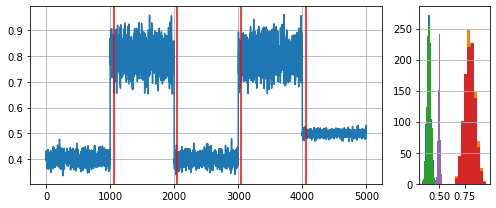

In [6]:
adwin = river.drift.ADWIN()
drifts_adw = []

for i, val in enumerate(stream):
    adwin.update(val)   # Data is processed one sample at a time
    if adwin.change_detected:
        # The drift detector indicates after each sample if there is a drift in the data
        print(f'Drift detected at index {i}')
        drifts_adw.append(i)
        adwin.reset()   # As a best practice, we reset the detector

plot_data(dist_a, dist_b, dist_c, dist_d, dist_e, drifts_adw)

## Fixed window

Kolmogorov-Smirnov Windowing ([KSWIN](https://riverml.xyz/dev/api/drift/KSWIN/)) method for concept drift detection.

Drift detected at index 903
Drift detected at index 2014
Drift detected at index 2794
Drift detected at index 3364
Drift detected at index 4011


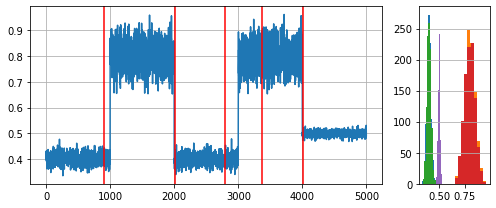

In [7]:
# window_size sets the sliding window's size
# for our stream the best window_size is 1000
kswin = river.drift.KSWIN(window_size = 600)
drifts_ksw = []


for i, val in enumerate(stream):
    in_drift, in_warning = kswin.update(val)
    if in_drift:
        print(f'Drift detected at index {i}')
        drifts_ksw.append(i)
        #drift_detector.reset()   # As a best practice, we reset the detector

plot_data(dist_a, dist_b, dist_c, dist_d, dist_e, drifts_ksw)

## Forgetting

[PageHinkley](https://riverml.xyz/dev/api/drift/PageHinkley/) detects a concept drift if the observed mean at some instant is greater then a threshold value lambda.

Change detected at index 1082
Change detected at index 1962
Change detected at index 3087
Change detected at index 3662


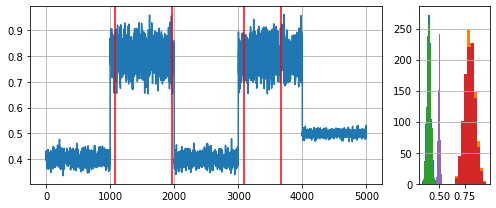

In [8]:
# min_instances: sets minimum number of instances before detecting change
# alpha: is forgetting factor, used to weight the observed value and the mean

# you can try with different values of min_instances and alpha 
# and observe where the drift is detected
# for our stream, the best values are min_instaces = 1000 and alpha ~ 1.03

ph = river.drift.PageHinkley(min_instances = 500, alpha = 1.01)

drifts_ph = []

# Update drift detector and verify if change is detected
for i, val in enumerate(stream):
    in_drift, in_warning = ph.update(val)
    if in_drift:
        print(f"Change detected at index {i}")
        drifts_ph.append(i)

plot_data(dist_a, dist_b, dist_c, dist_d, dist_e, drifts_ph)


In [9]:
# Phishing data set
#phishing = datasets.Phishing()

# Performance Evaluation

For performance evaluation, we will use scikit-multiflow

In [10]:
# install it with 
# !pip install scikit-multiflow

import skmultiflow

In [11]:
# Setting up a toy data stream with concept drift
ht_stream = skmultiflow.data.ConceptDriftStream()

# define the Hoeffding Tree estimator
ht = skmultiflow.trees.HoeffdingTreeClassifier(split_criterion='gini')

# Setup variables to control loop and track performance
n_samples = 0
correct_cnt = 0
max_samples = 20000

# Train the estimator with the samples from the data stream
while n_samples < max_samples and ht_stream.has_more_samples():
    X, y = ht_stream.next_sample()
    y_pred = ht.predict(X)
    if y[0] == y_pred[0]:
        correct_cnt += 1
    ht = ht.partial_fit(X, y)
    
    n_samples += 1

# Display results
print('{} samples analyzed.'.format(n_samples))
print('Hoeffding Tree accuracy: {}'.format(correct_cnt / n_samples))

20000 samples analyzed.
Hoeffding Tree accuracy: 0.91605


## Prequential Evaluation

Read more about [EvaluatePrequential](https://scikit-multiflow.readthedocs.io/en/stable/api/generated/skmultiflow.evaluation.EvaluatePrequential.html#skmultiflow.evaluation.EvaluatePrequential)

<IPython.core.display.Javascript object>


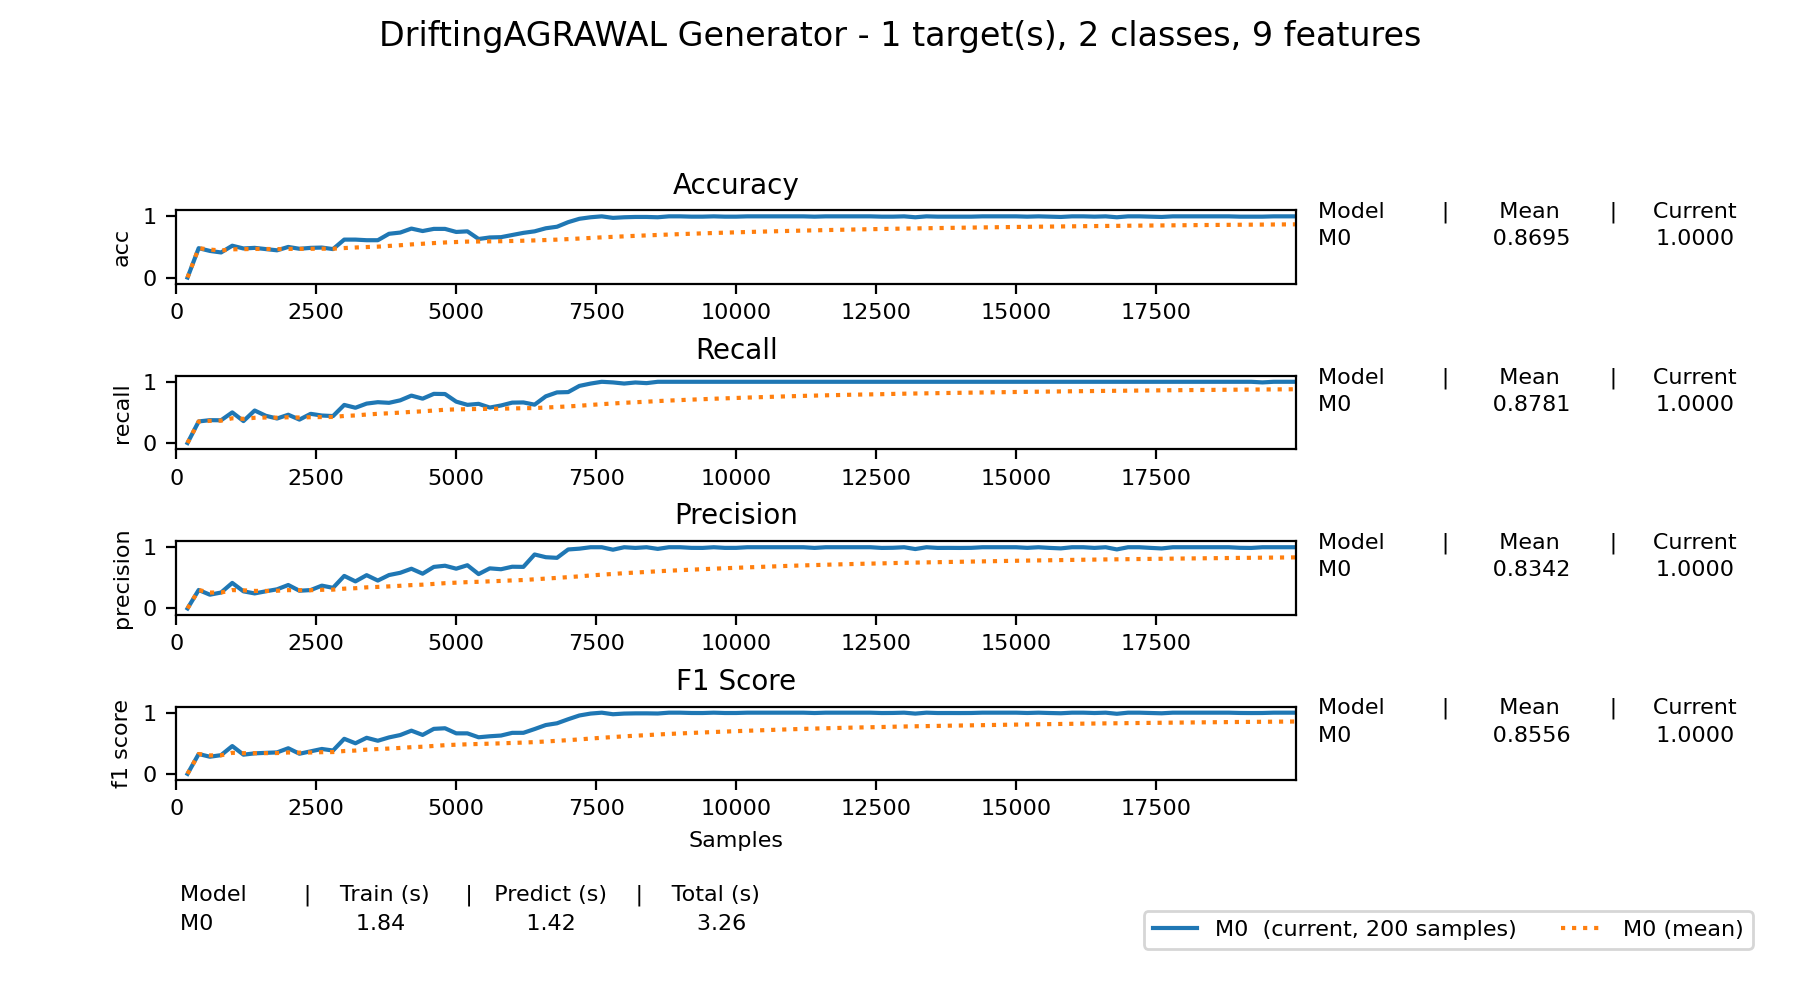

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [8.10s]
Processed samples: 20000
Mean performance:
M0 - Accuracy     : 0.8695
M0 - Precision: 0.8342
M0 - Recall: 0.8781
M0 - F1 score: 0.8556
M0 - Training time (s)  : 1.84
M0 - Testing time  (s)  : 1.42
M0 - Total time    (s)  : 3.26


[HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                         leaf_prediction='nba', max_byte_size=33554432,
                         memory_estimate_period=1000000, nb_threshold=0,
                         no_preprune=False, nominal_attributes=None,
                         remove_poor_atts=False, split_confidence=1e-07,
                         split_criterion='gini', stop_mem_management=False,
                         tie_threshold=0.05)]

In [14]:
%matplotlib notebook
preq_evaluator=skmultiflow.evaluation.EvaluatePrequential(show_plot=True,
                                                          data_points_for_classification=False,
                                                          max_samples=20000,
                                                          metrics=['accuracy', 'recall', 
                                                                   'precision' ,'f1', 'running_time'])

#run evaluation
preq_evaluator.evaluate(stream=ht_stream, model=ht)

## Holdout Evaluation

Read more about [EvaluateHoldout](https://scikit-multiflow.readthedocs.io/en/stable/api/generated/skmultiflow.evaluation.EvaluateHoldout.html)

<IPython.core.display.Javascript object>


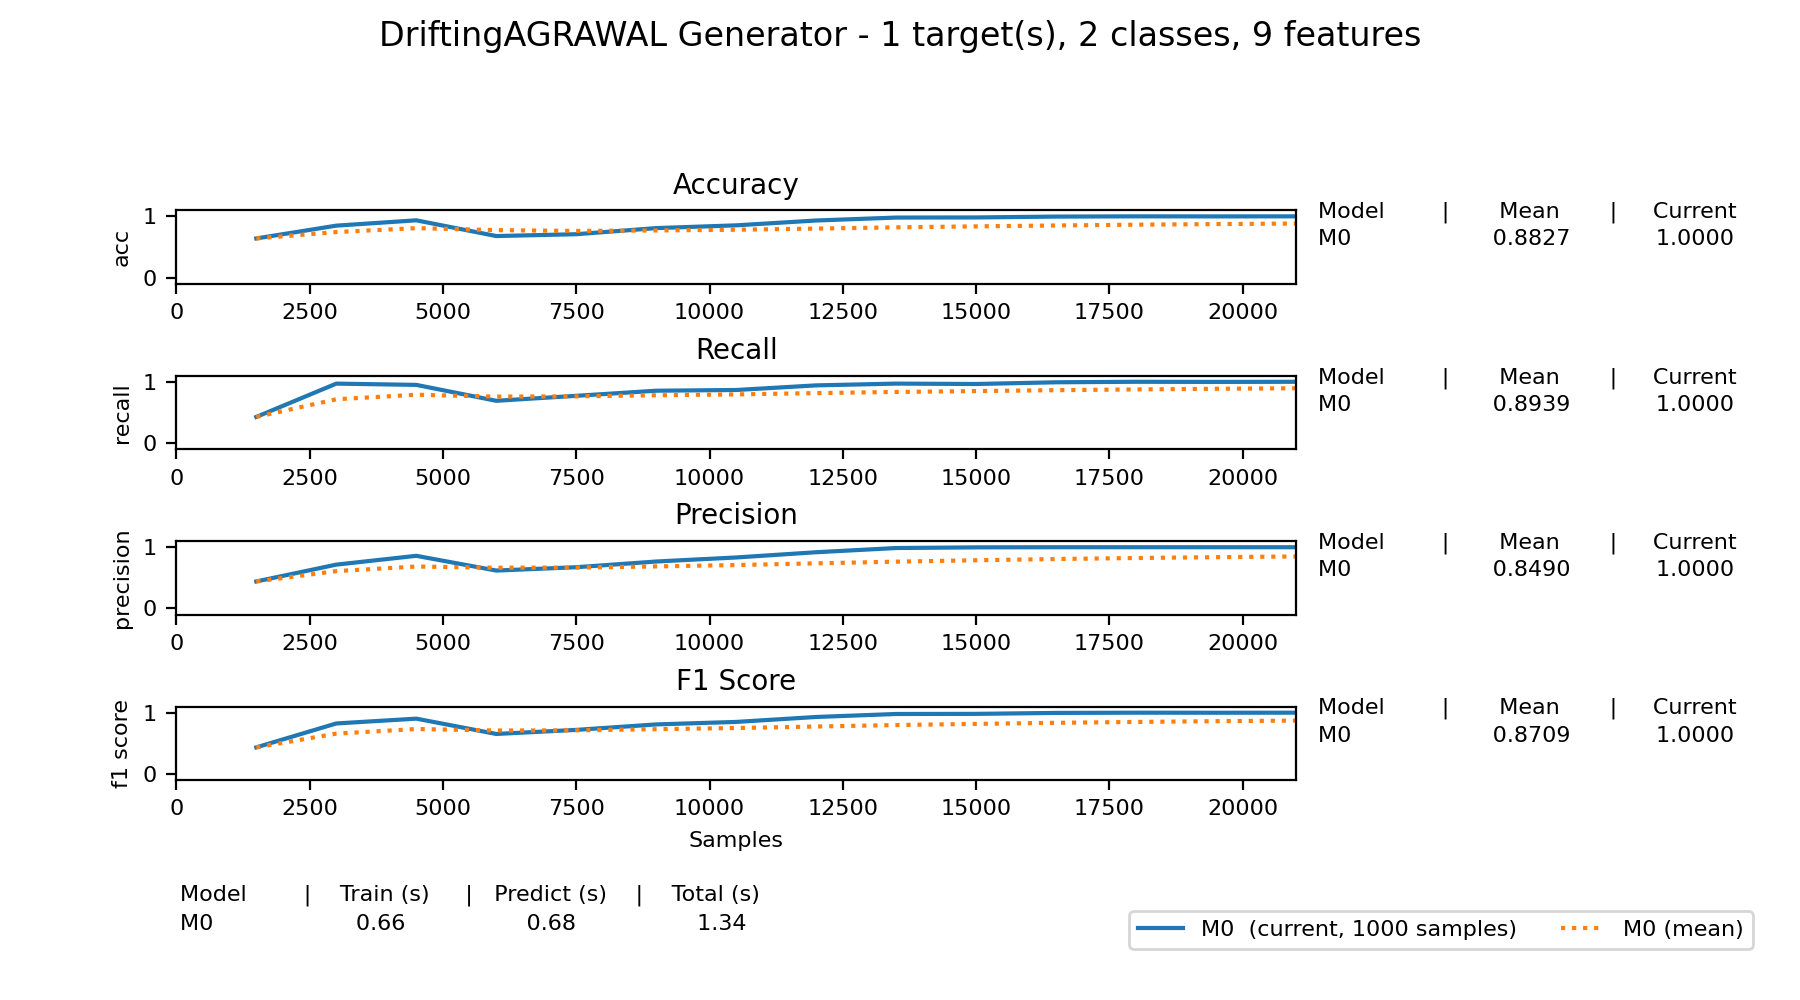

Holdout Evaluation
Evaluating 1 target(s).
Evaluating...
 -------------------- [0%] [0.00s]Separating 1000 holdout samples.
Separating 1000 holdout samples.
 ###----------------- [15%] [0.59s]Separating 1000 holdout samples.
Separating 1000 holdout samples.
 ######-------------- [30%] [1.01s]Separating 1000 holdout samples.
Separating 1000 holdout samples.
 #########----------- [45%] [1.61s]Separating 1000 holdout samples.
Separating 1000 holdout samples.
 ############-------- [60%] [2.07s]Separating 1000 holdout samples.
Separating 1000 holdout samples.
 ###############----- [75%] [2.62s]Separating 1000 holdout samples.
Separating 1000 holdout samples.
 ##################-- [90%] [3.02s]Separating 1000 holdout samples.
 #################### [100%] [3.32s]
Separating 1000 holdout samples.
Processed samples: 21000
Mean performance:
M0 - Accuracy     : 0.8827
M0 - Precision: 0.8490
M0 - Recall: 0.8939
M0 - F1 score: 0.8709
M0 - Training time (s)  : 0.66
M0 - Testing time  (s)  : 0.68
M0 

[HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                         leaf_prediction='nba', max_byte_size=33554432,
                         memory_estimate_period=1000000, nb_threshold=0,
                         no_preprune=False, nominal_attributes=None,
                         remove_poor_atts=False, split_confidence=1e-07,
                         split_criterion='gini', stop_mem_management=False,
                         tie_threshold=0.05)]

In [13]:
%matplotlib notebook
hold_evaluator = skmultiflow.evaluation.EvaluateHoldout(max_samples=20000,
                                                        n_wait = 500,
                                                        test_size = 1000,
                                                        show_plot=True,
                                                        metrics=['accuracy', 'recall',
                                                                 'precision' ,'f1', 'running_time'],
                                                        dynamic_test_set=True)
# Run evaluation
hold_evaluator.evaluate(stream=ht_stream, model=ht)